<a href="https://colab.research.google.com/github/AustinVes/Voter_Emotions/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sourcing Data



The data I analyse comes from the American National Election Studies (ANES). Specifically, I use data from their 2016 ANES Time Series Study on “electoral participation, voting behavior, public opinion, media exposure, cognitive style, and values and predispositions” of Americans during the 2016 elections.

*“ANES is a collaboration of Stanford University and the University of Michigan, with funding by the National Science Foundation… The mission of the American National Election Studies (ANES) is to inform explanations of election outcomes by providing… high quality data from its own surveys on voting, public opinion, and political participation.”* -[ANES](https://electionstudies.org/)

The 2016 ANES Time Series Study dataset mainly constitutes survey responses taken both before and after the elections.

*“Data collection for the ANES 2016 Time Series Study began in early September and continued into January, 2017. Pre-election interviews were conducted with study respondents during the two months prior to the 2016 elections and were followed by post-election reinterviewing beginning November 9, 2016… Face-to-face interviewing was complemented with data collection on the Internet.  Data collection was conducted in the two modes independently, using separate samples but substantially identical questionnaires. Web-administered cases constituted a representative sample separate from the face-to-face.”*  -[ANES](https://electionstudies.org/)

This dataset is currently available for free [here](https://electionstudies.org/data-center/2016-time-series-study/) from the ANES website, but you will need to have an account with ANES to download it. This repository also contains several copies of this dataset, downloaded 04/06/2020. The dataset comes with a [User Guide and Codebook](https://electionstudies.org/wp-content/uploads/2018/12/anes_timeseries_2016_userguidecodebook.pdf) and [Methodology Report](https://electionstudies.org/wp-content/uploads/2018/12/anes_timeseries_2016_userguidecodebook.pdf), along with many other supporting documents available [here](https://electionstudies.org/data-center/2016-time-series-study/).

Here are the Terms of Use from ANES, which I accept:
* Use these datasets solely for research or statistical purposes and not for investigation of specific survey respondents.
* Make no use of the identity of any survey respondent(s) discovered intentionally or inadvertently, and to advise ANES of any such discovery (anes@electionstudies.org)
* Cite ANES data and documentation in your work that makes use of the data and documentation. Authors of publications based on ANES data should send citations of their published works to ANES for inclusion in our bibliography of related publications.
* You acknowledge that the original collector of the data, ANES, and the relevant funding agency/agencies bear no responsibility for use of the data or for interpretations or inferences based upon such uses.

## Downloading

Because downloading the 2016 ANES Time Series Study dataset from the ANES website requires creating an account, for the purposes of loading it into this Google Colab notebook, I made a copy of the dataset available publically in this GitHub repository.

ANES offers this dataset in several different file formats. After experimenting with all the formats and confirming they contain the same amount of data, I chose to work with the "raw" ASCII file because I best understood how to manipulate it. That said, all the analysis I present here (after sanitation) is the same no matter which format you draw from.

In [0]:
import os

if not os.path.exists('anes_timeseries_2016_rawdata.txt'):
    !wget https://raw.githubusercontent.com/AustinVes/Voter_Emotions/master/data/ASCII/anes_timeseries_2016_rawdata.txt

The raw data file contains plaintext delimiter-separated values (delimiter = "|") in fixed-width columns. I load it into a Pandas dataframe with the low_memory flag disabled to avoid winding up with mixed-type columns from parsing the file in chunks.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('anes_timeseries_2016_rawdata.txt', delimiter='|', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4270 entries, 0 to 4269
Columns: 1842 entries, version to V168528
dtypes: float64(14), int64(1790), object(38)
memory usage: 60.0+ MB


## Understanding the Data Structure

Everything in this section is explained in greater detail in the [User Guide and Codebook](https://electionstudies.org/wp-content/uploads/2018/12/anes_timeseries_2016_userguidecodebook.pdf).

This dataset consists entirely of survey data. Each column corresponds to a variable describing some aspect of the interviews (responses to a survey question, info about testing conditions, sampling weights, etc.). Each row corresponds to an individual respondent and is persistent through the whole study, meaning that even if a respondent was interviewed multiple times, their data is all contained in their one row.

This dataset includes results from two distinct interview methodologies: face-to-face (FtF) and online survey. In both cases, interviews were carried out on a sampling of people pre-election and then a subset of those people were also interviewed post-election. Nobody was interviewed post-election that wasn't interviewed pre-election. Respondants from each respective methodology make up their own stratified samples but the dataset provides weights for combining the two groups if you want to analyze them together.

This study was carried out using stratified sampling. Along with each row, the dataset provides a number of different weights for bootstrapping representative samples of U.S. voters, depending on which of the following subsets of respondents you want to analyze:<br/>
* full sample using post‐election survey only or both pre and post<br/>
* full sample using pre‐election survey data only<br/>
* face‐to‐face mode alone, using the post‐election survey or both pre and * post<br/>
* face‐to‐face mode alone, using pre‐election survey data only<br/>
* Internet mode alone, using data from both pre‐ and post‐election or post alone<br/>
* Internet mode alone, using data from only the pre‐election survey

The variables all follow the same naming convention, that is:<br/>
"V" + study year (YY) + 1-digit section ID + 3-digit unique code (+ optional letter)<br/>
Examples: V166002, V162371b, V164012<br/>
The section ID code refers to which part of the study that variable is from (e.g. pre‐election interview, post‐election administrative variables, etc.). Beyond that, this naming scheme makes it impossible to intuit and difficult to remember what each variable means. If you want to work with this dataset, be ready to constantly cross-reference the codebook.

The values of categorical variables are encoded numerically as described in the codebook. Missing data is also encoded numerically as such:<br/>
‐1 = Inapplicable<br/>
‐2 = Text responses available in separate file or coded version will be included in future release<br/>
‐3 = Restricted<br/>
‐4 = Error<br/>
‐5 = Breakoff, sufficient partial IW<br/>
‐6 = No post‐election interview<br/>
‐7 = No post data, deleted due to incomplete IW<br/>
‐8 = Don’t know<br/>
‐9 = Refused<br/>
...At least in theory. I found a few odd exceptions to these rules in the dataset, which leads nicely into the next step of the process:

## Sanitizing

In exploring the dataset, the only obvious errors I found were related to these missing data codes. For instance, though almost all columns use these codes where there would otherwise be nothing, there is exactly one column in the whole dataset that uses empty cells instead: V162084. It being the only example and there being no justification given, I assume this was a mistake. I replace all the "empty" cells (they actually contain three spaces) with -4.

In [0]:
V162084_empty = df['V162084'].str.isspace()
df.loc[V162084_empty, 'V162084'] = -4

Next, almost all columns just code missing data as numbers (e.g. -1), but some columns also include the description of each missing data code (e.g. "-1. Inapplicable") which means those columns get interpreted incorrectly as objects (strings). I identify these cells using a regex that matches the sequence of a minus sign, a single digit, a period, then a space, and I replace them with their intended numerical value.

In [0]:
import re

def remove_missing_data_desc(cell):
  if type(cell) == str and re.search('-\d. ', cell):
    return pd.to_numeric(cell[:cell.find('.')])
  else:
    return cell

object_cols = df.select_dtypes(include='object')
df.update(object_cols.applymap(remove_missing_data_desc))

Now that I've removed all erroneous text from the missing data codes, I ask Pandas to re-interpret each object column's datatype to make every column numerical that should be.

In [5]:
df = df.apply(pd.to_numeric, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4270 entries, 0 to 4269
Columns: 1842 entries, version to V168528
dtypes: float64(14), int64(1808), object(20)
memory usage: 60.0+ MB


In addition to the error codes provided at the beginning of the codebook, I also found these error codes used in many columns:<br/>
-99 = Refused<br/>
-89 = Don't recognize (don't know who this is)<br/>
-88 = Don’t know (where to rate)<br/>
96 = Don’t know<br/>
97 = Refused<br/>
99 = Not answered; The answer recorded by the interviewer is uninterpretable<br/>
99 = Unknown<br/>
99 = Haven’t thought much about this<br/>
998 = Don’t know (where to rate)<br/>
999 = Don’t recognize (don’t know who this is)<br/>
9998 = Don't know<br/>
9999 = Refused

Again, I don't know why these were included except that they were mistakes. Some of these are present in around 100 columns, in many cases alongside the correct codes. All of them ignore the otherwise established conventions for numbering. Several of them are redundant both with each other and with the existing codes. There is a 96, 97, and 99, but no 98 (I checked). Worst of all, not only is 99 used to mean three different things, but it's also a genuine datapoint in several columns.

To begin correcting these errant codes, I map each of them to the documented missing data code they most closely represent:

In [0]:
correct_codes = pd.Series({
    -99: -9,
    -89: -8,
    -88: -8,
    96: -8,
    97: -9,
    99: -9,
    998: -8,
    999: -8,
    9998: -8,
    9999: -9
})

Next, I replace all cases I know for sure are one of these errant codes with their appropriate counterpart. I am sure -99, -89, and -88 are always missing data codes because all numerical data in this dataset is positive. I am also sure 998, 999, 9998, and 9999 are always missing data codes because all numerical data in this dataset is within the range 0-100 (with the exception of one column, V161264x, which encodes its categorical data with 3-digit numerical-codes but does not contain 998 or 999).

In [0]:
df.replace(correct_codes.drop(labels=[96,97,99]), inplace=True)

Finally, I replace all cases where 96, 97, or 99 are being used as missing data codes and not as genuine datapoints. I determine which is which through a litmus test I discovered by exploring the dataset: 96, 97, and 99 are not used as missing data codes in any column with actual values greater than 15. Likewise, 96, 97, and 99 are not used as actual data in any column where the next greatest value is less than 50.

In [0]:
from pandas.api.types import is_numeric_dtype

def fix_unclear_codes(col):
  unclear_codes = [96,97,99]
  col = col.copy()
  orig_col = col.copy()

  # remove all non-numeric values from series
  col = col[col.apply(lambda x: is_numeric_dtype(type(x)))]
  # remove all instances of potential missing data codes from series
  col = col[col.apply(lambda x: x not in unclear_codes)]
  
  if col.max() < 101:
    orig_col = orig_col.apply(lambda x: correct_codes[x] if x in unclear_codes else x)
  
  return orig_col

df = df.apply(fix_unclear_codes)

At this point, the entire dataset is sanitized so that there are no empty cells, all numerical columns are actually formatted as such, and only the most appropriate missing data codes as documented in the beginning of the codebook are used. If you want to work with the dataframe in this condition, you should stop here...

For my purposes, though, I don't need to know why any given piece of data is missing. I would actually prefer that these missing data codes not interfere with my mathematical analysis. For that reason, I go back on a portion of the work I just accomplished by replacing all the missing data codes in the dataset with NaNs:

In [0]:
df = df.applymap(lambda x: np.nan if (is_numeric_dtype(type(x)) and x < 0) else x)

## Validating

V160101 - Pre-election weight -full sample<br/>
V160101f - Pre-election weight -FTF sample<br/>
V160101w - Pre-election weight -Web sample<br/>
V160502 - Completed Pre only or completed Pre and Post interviews<br/>
<br/>
V161019 - PRE: Party of registration<br/>
V161126 - PRE: 7pt scale Liberal conservative self-placement<br/>
V161127 - PRE: If R had to choose liberal or conservative self-placemt<br/>
V161267 - PRE: Respondent age<br/>
V161267c - PRE: Birthdate: year of birth<br/>
V161270 - PRE: Highest level of Education<br/>
V161271 - PRE: R high school completion- diploma or GED<br/>
V161310x - PRE: SUMMARY - R self-identified race<br/>
V165508 - FTF SCREENER: SCRN_SEX_S. Screener R sex<br/>
V165723 - WEB SCREENER: S7. Gender<br/>
V161361x - PRE FTF CASI/WEB: Pre income summary<br/>
<br/>
V161030 - PRE: Does R intend to vote for President<br/>
V161031 - PRE: For whom does R intend to vote for President<br/>
V161032 - PRE: Pref strng for Pres cand for whom R intends to vote<br/>
V161086 - PRE: Feeling Thermometer: Democratic Presidential cand<br/>
V161087 - PRE: Feeling Thermometer: Republican Presidential cand<br/>
V161095 - PRE: Feeling Thermometer: Democratic Party<br/>
V161096 - PRE: Feeling Thermometer: Republican Party<br/>
V162031x - PRE-POST: SUMMARY - Did R vote in 2016<br/>
V162034 - POST: Did R vote for President<br/>
V162034a - POST: For whom did R vote for President<br/>
<br/>
V161116 - PRE: Affect for Democratic Pres cand: angry<br/>
V161117 - PRE: Affect for Democratic Pres cand: hopeful<br/>
V161118 - PRE: Affect for Democratic Pres cand: afraid<br/>
V161119 - PRE: Affect for Democratic Pres cand: proud<br/>
V161120 - PRE: Affect for Democratic Pres cand: disgusted<br/>
V161121 - PRE: Affect for Republican Pres cand: angry<br/>
V161122 - PRE: Affect for Republican Pres cand: hopeful<br/>
V161123 - PRE: Affect for Republican Pres cand: afraid<br/>
V161124 - PRE: Affect for Republican Pres cand: proud<br/>
V161125 - PRE: Affect for Republican Pres cand: disgusted<br/>

In [0]:
key_vars = {
  'V160101':  { 'prefix': '',       'desc': 'Pre-election weight -full sample' },
  'V160101f': { 'prefix': '',       'desc': 'Pre-election weight -FTF sample' },
  'V160101w': { 'prefix': '',       'desc': 'Pre-election weight -Web sample' },
  'V160502':  { 'prefix': '',       'desc': 'Completed Pre only or completed Pre and Post interviews' },

  'V161019':  { 'prefix': 'PRE',    'desc': 'Party of registration' },
  'V161126':  { 'prefix': 'PRE',    'desc': '7pt scale Liberal conservative self-placement' },
  'V161127':  { 'prefix': 'PRE',    'desc': 'If R had to choose liberal or conservative self-placemt' },
  'V161267':  { 'prefix': 'PRE',    'desc': 'Respondent age' },
  'V161267c': { 'prefix': 'PRE',    'desc': 'Birthdate: year of birth' },
  'V161270':  { 'prefix': 'PRE',    'desc': 'Highest level of Education' },
  'V161271':  { 'prefix': 'PRE',    'desc': 'R high school completion- diploma or GED' },
  'V161310x': { 'prefix': 'PRE',    'desc': 'SUMMARY - R self-identified race' },
  'V165508':  { 'prefix': 'FTF SCREENER', 'desc': 'SCRN_SEX_S. Screener R sex' },
  'V165723':  { 'prefix': 'WEB SCREENER', 'desc': 'S7. Gender' },
  'V161361x': { 'prefix': 'PRE FTF CASI/WEB', 'desc': 'Pre income summary' },

  'V161030':  { 'prefix': 'PRE',    'desc': 'Does R intend to vote for President' },
  'V161031':  { 'prefix': 'PRE',    'desc': 'For whom does R intend to vote for President' },
  'V161032':  { 'prefix': 'PRE',    'desc': 'Pref strng for Pres cand for whom R intends to vote' },
  'V161086':  { 'prefix': 'PRE',    'desc': 'Feeling Thermometer: Democratic Presidential cand' },
  'V161087':  { 'prefix': 'PRE',    'desc': 'Feeling Thermometer: Republican Presidential cand' },
  'V161095':  { 'prefix': 'PRE',    'desc': 'Feeling Thermometer: Democratic Party' },
  'V161096':  { 'prefix': 'PRE',    'desc': 'Feeling Thermometer: Republican Party' },
  'V162031x': { 'prefix': 'PRE-POST', 'desc': 'SUMMARY -Did R vote in 2016' },
  'V162034':  { 'prefix': 'POST',   'desc': 'Did R vote for President' },
  'V162034a': { 'prefix': 'POST',   'desc': 'For whom did R vote for President' },
  
  'V161116':  { 'prefix': 'PRE',    'desc': 'Affect for Democratic Pres cand: angry' },
  'V161117':  { 'prefix': 'PRE',    'desc': 'Affect for Democratic Pres cand: hopeful' },
  'V161118':  { 'prefix': 'PRE',    'desc': 'Affect for Democratic Pres cand: afraid' },
  'V161119':  { 'prefix': 'PRE',    'desc': 'Affect for Democratic Pres cand: proud' },
  'V161120':  { 'prefix': 'PRE',    'desc': 'Affect for Democratic Pres cand: disgusted' },
  'V161121':  { 'prefix': 'PRE',    'desc': 'Affect for Republican Pres cand: angry' },
  'V161122':  { 'prefix': 'PRE',    'desc': 'Affect for Republican Pres cand: hopeful' },
  'V161123':  { 'prefix': 'PRE',    'desc': 'Affect for Republican Pres cand: afraid' },
  'V161124':  { 'prefix': 'PRE',    'desc': 'Affect for Republican Pres cand: proud' },
  'V161125':  { 'prefix': 'PRE',    'desc': 'Affect for Republican Pres cand: disgusted' }
}

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


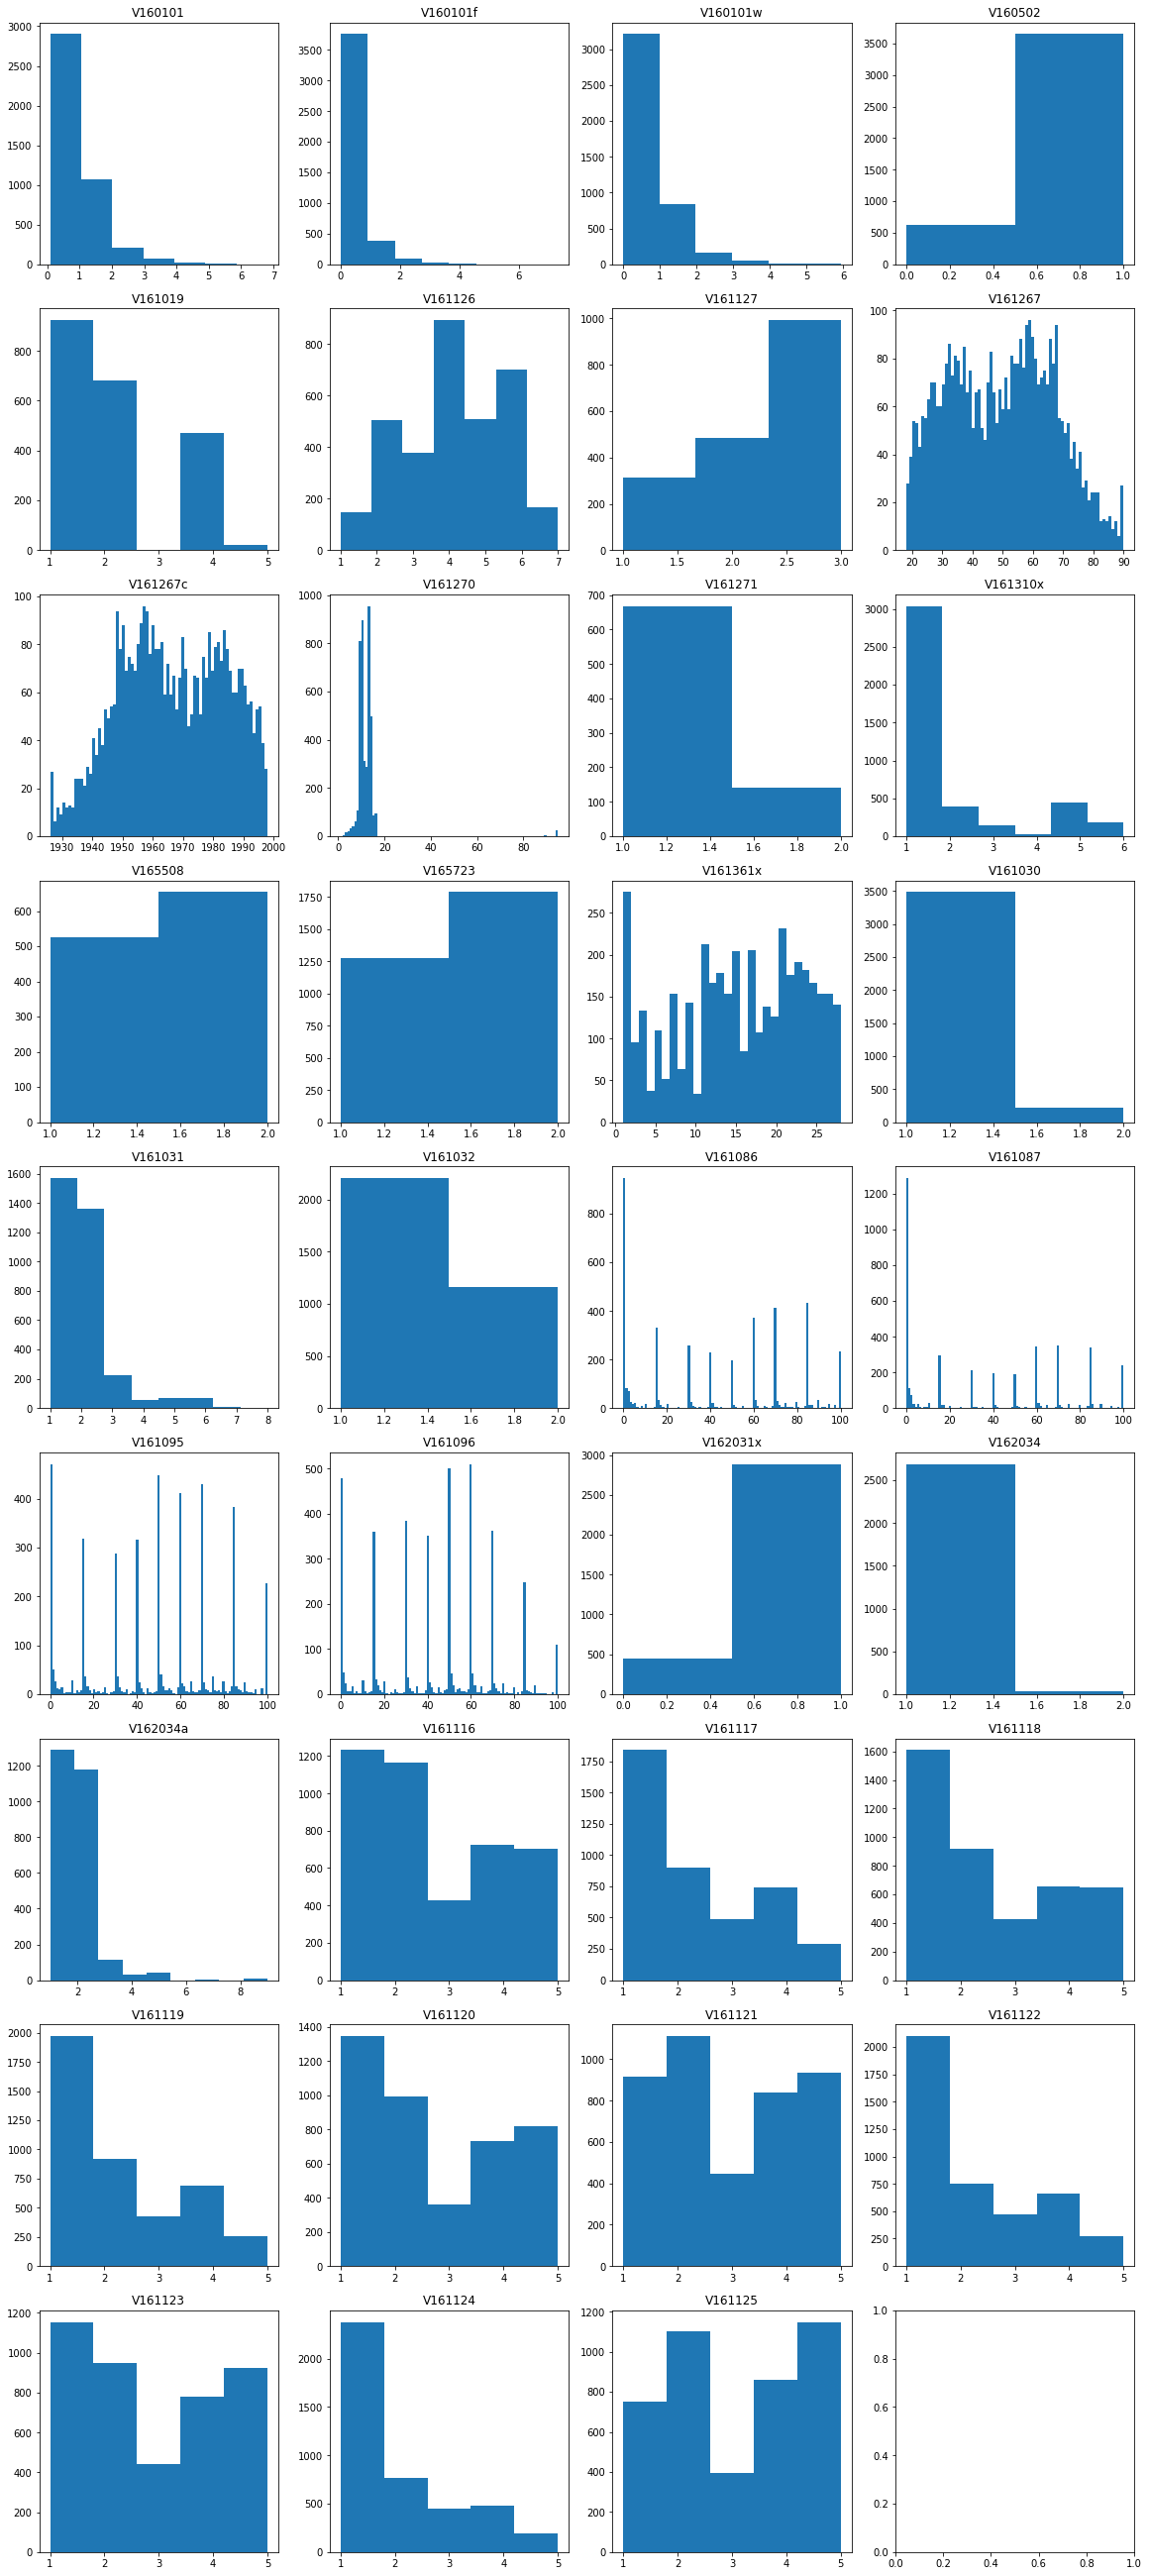

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = 4
rows = int(np.ceil(len(key_vars)/cols))

fig, axs = plt.subplots(rows, cols, constrained_layout=True)
fig.set_size_inches(4*cols, 4*rows)
#fig.subplots_adjust(hspace=0.3)

for n,var_name in enumerate(key_vars):
  x = int(np.floor(n/cols))
  y = int(n % cols)
  var_range = df[var_name].max() - df[var_name].min()
  axs[x,y].hist(df[var_name].dropna().values, bins=int(var_range)+1)
  axs[x,y].set_title(var_name)

In [12]:
key_vars.keys()

dict_keys(['V160101', 'V160101f', 'V160101w', 'V160502', 'V161019', 'V161126', 'V161127', 'V161267', 'V161267c', 'V161270', 'V161271', 'V161310x', 'V165508', 'V165723', 'V161361x', 'V161030', 'V161031', 'V161032', 'V161086', 'V161087', 'V161095', 'V161096', 'V162031x', 'V162034', 'V162034a', 'V161116', 'V161117', 'V161118', 'V161119', 'V161120', 'V161121', 'V161122', 'V161123', 'V161124', 'V161125'])

In [13]:
var_name = 'V161125'
val_freqs = df[var_name].value_counts().head(20)
if val_freqs.size < 20: val_freqs.sort_index(inplace=True)
print(val_freqs)
print()
print(df[var_name].describe())

1.0     750
2.0    1104
3.0     393
4.0     862
5.0    1149
Name: V161125, dtype: int64

count    4258.000000
mean        3.130578
std         1.493027
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max         5.000000
Name: V161125, dtype: float64


## Resampling

In [0]:
# note that these are only representative samples for analysing pre-election data
full = df.sample(n=len(df), replace=True, weights=df['V160101'], random_state=2131)
ftf = df.sample(n=len(df), replace=True, weights=df['V160101f'], random_state=3531)
web = df.sample(n=len(df), replace=True, weights=df['V160101w'], random_state=2020)
# the PRNG seeds are just an easter egg, they're not relevant to the analysis

## Testing Assumptions

In [0]:
sns.set_palette('colorblind')

In [0]:
def describe_xticklabels(ax, var_name):
  if var_name in key_vars and 'cat_map' in key_vars[var_name]:
    str_cats = {str(k): v for k,v in key_vars[var_name]['cat_map'].items()}
    x_labels = ax.get_xticklabels()
    for text_obj in x_labels: text_obj.set_text(str_cats[text_obj.get_text()])
    ax.set_xticklabels(x_labels, rotation=30, horizontalalignment='right')

In [0]:
def compare_col_in_samples(col_name, samples, plot=True, ax_obj=None, n_boot = 100):
  cols = pd.DataFrame({name: smp[col_name].values for name,smp in samples.items()})
  boots = pd.DataFrame(columns = ['Category', 'Sample', 'Percentage'])
  for i in range(n_boot):
    boots = (cols.sample(n=len(cols), replace=True, random_state=i)
                 .apply(pd.Series.value_counts, normalize=True)
                 .mul(100)
                 .reset_index()
                 .rename(columns = {'index': 'Category'})
                 .pipe(pd.melt, id_vars='Category', var_name='Sample', value_name='Percentage')
                 .append(boots, ignore_index=True))
  ax = sns.barplot(data = boots, x='Category', y='Percentage', hue='Sample', ax=ax_obj)
  ax.set_title(col_name)
  if col_name in key_vars: ax.set_title(f"{col_name}: {key_vars[col_name]['desc']}")
  describe_xticklabels(ax, col_name)
  if plot: ax.plot()

samples = {'full': full, 'ftf': ftf, 'web': web}

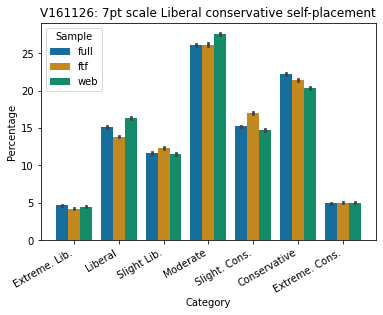

In [81]:
key_vars['V161126']['cat_map'] = {
    1.0: 'Extreme. Lib.',
    2.0: 'Liberal',
    3.0: 'Slight Lib.',
    4.0: 'Moderate',
    5.0: 'Slight. Cons.',
    6.0: 'Conservative',
    7.0: 'Extreme. Cons.'
}

compare_col_in_samples('V161126', samples)

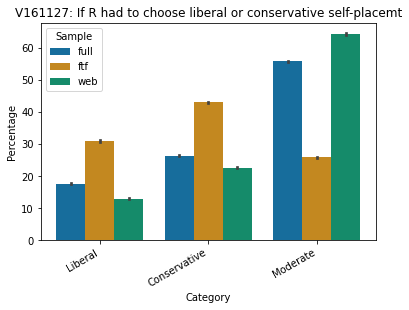

In [82]:
key_vars['V161127']['cat_map'] = {
    1.0: 'Liberal',
    2.0: 'Conservative',
    3.0: 'Moderate'
}

compare_col_in_samples('V161127', samples)

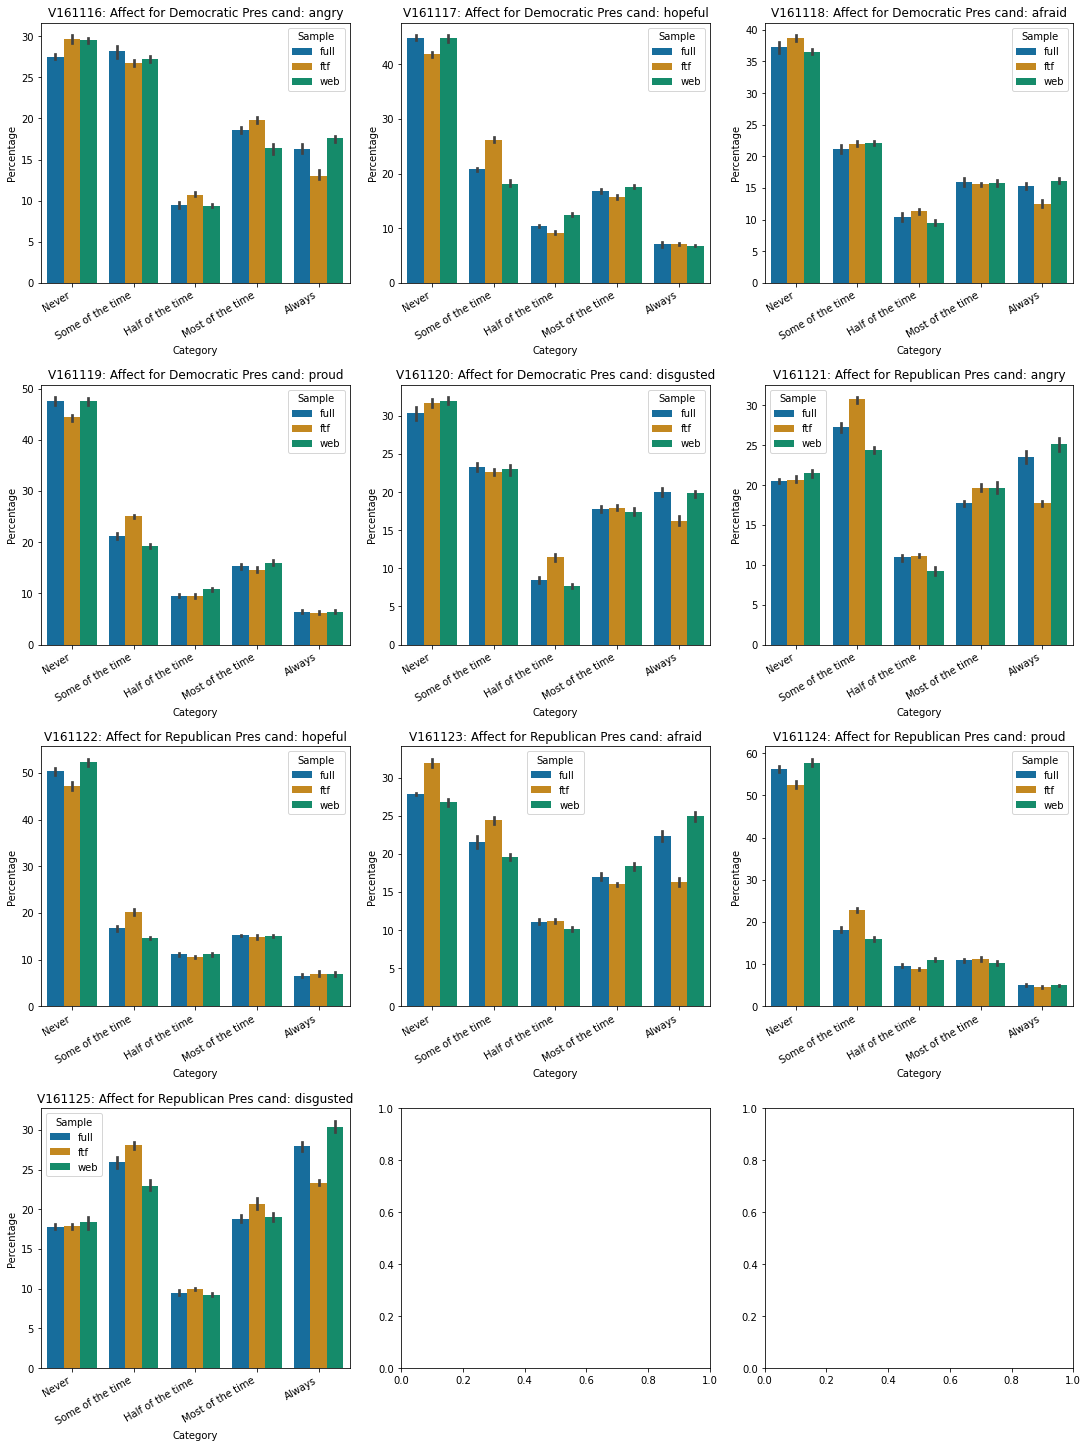

In [84]:
reaction_vars = ['V1611'+str(n) for n in range(16,26)]

cols = 3
rows = int(np.ceil(len(reaction_vars)/cols))

fig, axs = plt.subplots(rows, cols, constrained_layout=True)
fig.set_size_inches(5*cols, 5*rows)

for n,var_name in enumerate(reaction_vars):
  key_vars[var_name]['cat_map'] = {
      1.0: 'Never',
      2.0: 'Some of the time',
      3.0: 'Half of the time',
      4.0: 'Most of the time',
      5.0: 'Always'
  }
  x = int(np.floor(n/cols))
  y = int(n % cols)
  compare_col_in_samples(var_name, samples, plot=False, ax_obj=axs[x,y], n_boot=5)


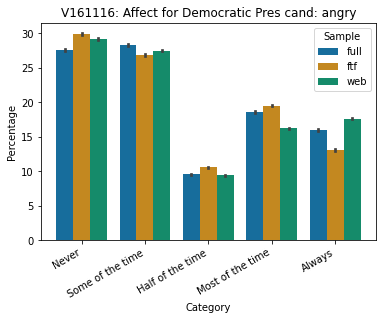

In [85]:
compare_col_in_samples('V161116', samples)

In [86]:
big_2_voters_pre = b2v_pre = full['V161031'] <= 2
voted = full['V162031x'] == 1
known_vote_post = kv_post = full['V162034a'].notna()
voted_for_intended = full[b2v_pre & (kv_post | voted)]['V161031'] == full[b2v_pre & (kv_post | voted)]['V162034a']
voted_for_intended.mean()
# at least 95% of people who said they would vote for Clinton or Trump, respectively, did so
# could be biased by people who didn't vote refusing to do the follow-up interview

0.956501182033097

In [0]:
big_2_voters = b2v = big_2_voters_pre

# Modeling